<a href="https://colab.research.google.com/github/junduk123/Machine-Learning-Task/blob/main/Task12/CNN_Fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Definisi Arsitektur CNN
class CNN(nn.Module):
    def __init__(self, kernel_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Dataset Fashion MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Fungsi Training Model
def train_model(model, optimizer, scheduler, criterion, epochs, early_stop_patience):
    train_loss, val_loss = [], []
    best_loss = float('inf')
    patience = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        train_loss.append(running_loss / len(train_loader))

        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
        val_loss.append(validation_loss / len(test_loader))

        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            patience = 0
        else:
            patience += 1

        if patience >= early_stop_patience:
            print(f"Penghentian awal pada epoch {epoch+1}")
            break

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}")

    return train_loss, val_loss

# Pengaturan Hyperparameter dan Proses Training
kernel_sizes = [3, 5, 7]  # Pilihan ukuran kernel
epochs_options = [5, 50, 100  ]  # Jumlah epoch yang diuji
optimizers = [optim.SGD, optim.RMSprop, optim.Adam]  # Optimizer yang digunakan
early_stop_patience = 10  # Patokan early stopping
learning_rate = 0.001  # Tingkat pembelajaran (learning rate)

results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for kernel_size in kernel_sizes:
    for epoch_option in epochs_options:
        for optimizer_class in optimizers:
            print(f"Training dengan kernel_size={kernel_size}, epochs={epoch_option}, optimizer={optimizer_class.__name__}")

            model = CNN(kernel_size=kernel_size).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optimizer_class(model.parameters(), lr=learning_rate)
            scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

            train_loss, val_loss = train_model(model, optimizer, scheduler, criterion, epoch_option, early_stop_patience)

            results.append({
                "kernel_size": kernel_size,
                "epochs": epoch_option,
                "optimizer": optimizer_class.__name__,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "final_train_loss": train_loss[-1],
                "final_val_loss": val_loss[-1]
            })

# Konversi hasil ke DataFrame dan Visualisasi
results_df = pd.DataFrame(results)




Training dengan kernel_size=3, epochs=5, optimizer=SGD
Epoch 1/5, Train Loss: 2.2261398466411175, Val Loss: 2.085915768981739
Epoch 2/5, Train Loss: 1.6235006161844299, Val Loss: 1.1281051916681277
Epoch 3/5, Train Loss: 0.9067421474182276, Val Loss: 0.7904852507220712
Epoch 4/5, Train Loss: 0.7304569797983556, Val Loss: 0.714704297720247
Epoch 5/5, Train Loss: 0.6757768595269494, Val Loss: 0.6863974564394374
Training dengan kernel_size=3, epochs=5, optimizer=RMSprop
Epoch 1/5, Train Loss: 0.46303943072809084, Val Loss: 0.33832076334269945
Epoch 2/5, Train Loss: 0.29570808026518647, Val Loss: 0.2971191449909453
Epoch 3/5, Train Loss: 0.24656930861315493, Val Loss: 0.31217679813219484
Epoch 4/5, Train Loss: 0.21616758160324875, Val Loss: 0.25794687629884977
Epoch 5/5, Train Loss: 0.19421242784732567, Val Loss: 0.2525734962409089
Training dengan kernel_size=3, epochs=5, optimizer=Adam
Epoch 1/5, Train Loss: 0.4802791292447525, Val Loss: 0.35607781379845493
Epoch 2/5, Train Loss: 0.303644

5 Hasil Hyperparameter CNN Terbaik:
    kernel_size  epochs optimizer  \
11            5       5      Adam   
2             3       5      Adam   
20            7       5      Adam   
1             3       5   RMSprop   
10            5       5   RMSprop   

                                           train_loss  \
11  [0.45960060394267793, 0.29155570424314753, 0.2...   
2   [0.4802791292447525, 0.30364405164427594, 0.25...   
20  [0.45077541028894086, 0.2906034901611078, 0.24...   
1   [0.46303943072809084, 0.29570808026518647, 0.2...   
10  [0.4887439204272685, 0.3037713185937674, 0.255...   

                                             val_loss  final_train_loss  \
11  [0.34456243797851976, 0.27270254791732046, 0.2...          0.188384   
2   [0.35607781379845493, 0.29096844526612836, 0.2...          0.201943   
20  [0.3518620387763734, 0.3063930394068645, 0.287...          0.190135   
1   [0.33832076334269945, 0.2971191449909453, 0.31...          0.194212   
10  [0.4212187518169925

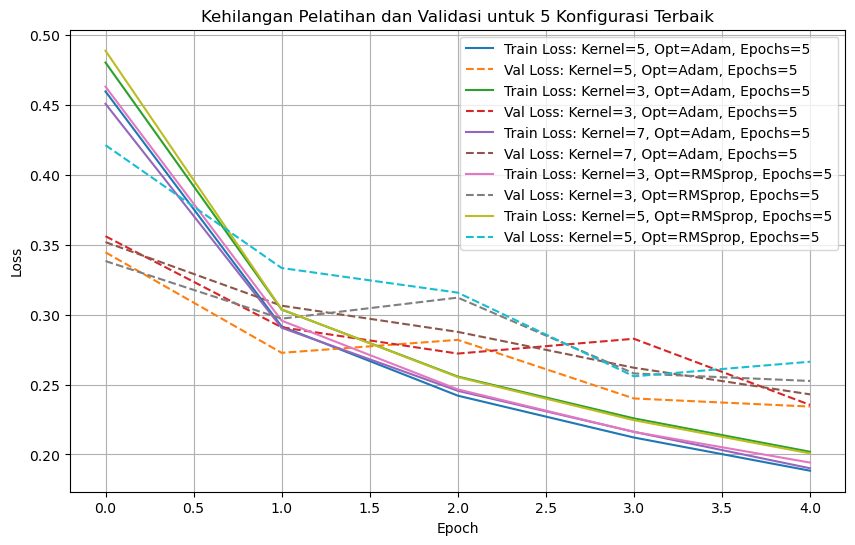

In [ ]:
# Menampilkan 5 konfigurasi terbaik berdasarkan kehilangan validasi terendah
top_5_results = results_df.nsmallest(5, 'final_val_loss')

# Tampilkan 5 hasil terbaik
print("5 Hasil Hyperparameter CNN Terbaik:")
print(top_5_results)

# Visualisasi: Kehilangan Validasi untuk 5 Konfigurasi Terbaik
plt.figure(figsize=(10, 6))
for index, row in top_5_results.iterrows():
    plt.plot(
        range(len(row["train_loss"])),
        row["train_loss"],
        label=f'Train Loss: Kernel={row["kernel_size"]}, Opt={row["optimizer"]}, Epochs={row["epochs"]}',
    )
    plt.plot(
        range(len(row["val_loss"])),
        row["val_loss"],
        label=f'Val Loss: Kernel={row["kernel_size"]}, Opt={row["optimizer"]}, Epochs={row["epochs"]}',
        linestyle="--",
    )

plt.title("Kehilangan Pelatihan dan Validasi untuk 5 Konfigurasi Terbaik")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()